<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/model_image_difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16:9 Generative Model
This notebook takes images that are in a 4:3 aspect ratio and adds to the image to shift them to a 16:9 aspect ratio.

## Imports and Parameters

In [1]:
import shutil
import pandas as pd
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# network parameters
BATCH_SIZE = 10
N_GPU = 0
N_WORKERS = 1
N_EPOCHS = 10
DATASET_SIZE = 24000

# image
IMG_SIZE = 256
SINGLE_SIDE_BLACKOUT = 32

# directories
IMG_DIR = '/content/gdrive/My Drive/repos/16:9GAN/data_out/frames/'
LOG_DIR = '/content/gdrive/My Drive/repos/16:9GAN/data_out/logs/'

# testing index
testing_index = [1000]

# images to spot check progress
check_images = ['0/fr5280.jpg']
check_images = [IMG_DIR + c for c in check_images]

# checkpoint type
CHECKPOINT_TYPE = 'prev_checkpoint' # none or prev_checkpoint

## Data

In [3]:
img_list = glob.glob(IMG_DIR + '*/*.jpg')
img_list = img_list[:DATASET_SIZE]
print('Number of images: %d' % len(img_list))

Number of images: 24000


In [4]:
# function for zeroing out the ends of an image and make them 4:3
def img_crop(img):
    pixels = img.load()

    for x in range(SINGLE_SIDE_BLACKOUT):
        for y in range(IMG_SIZE):
            pixels[x, y] = (0, 0, 0)
            pixels[IMG_SIZE - x - 1, y] = (0, 0, 0)

    return (img)

In [5]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):

    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image169 = Image.open(self.img_list[idx]).convert('RGB')

        if self.transform is not None:
            image169 = self.transform(image169)


        # zeros out the sides of the 16:9 image to get a 4:3
        image43 = image169.clone()
        for x in range(SINGLE_SIDE_BLACKOUT):
            for y in range(IMG_SIZE):
                for i in range(3):
                    image43[i][y][x] = -1
                    image43[i][y][IMG_SIZE - 1 - x] = -1

        return (image43, image169)

In [6]:
# makes the dataset and data loader
dataset_train = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    # transforms.RandomVerticalFlip(p=0.5),
                                    # transforms.CenterCrop(IMG_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
                        )

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print('Size of training dataset: %d' % len(dataloader_train.dataset))
n_batches = len(dataloader_train.dataset) / BATCH_SIZE

dataset_test = torch.utils.data.Subset(dataset_train, testing_index)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print('Size of testing dataset: %d' % len(dataloader_test.dataset))

Size of training dataset: 24000
Size of testing dataset: 1


In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")

### Plot some random images of 4:3 and 16:9

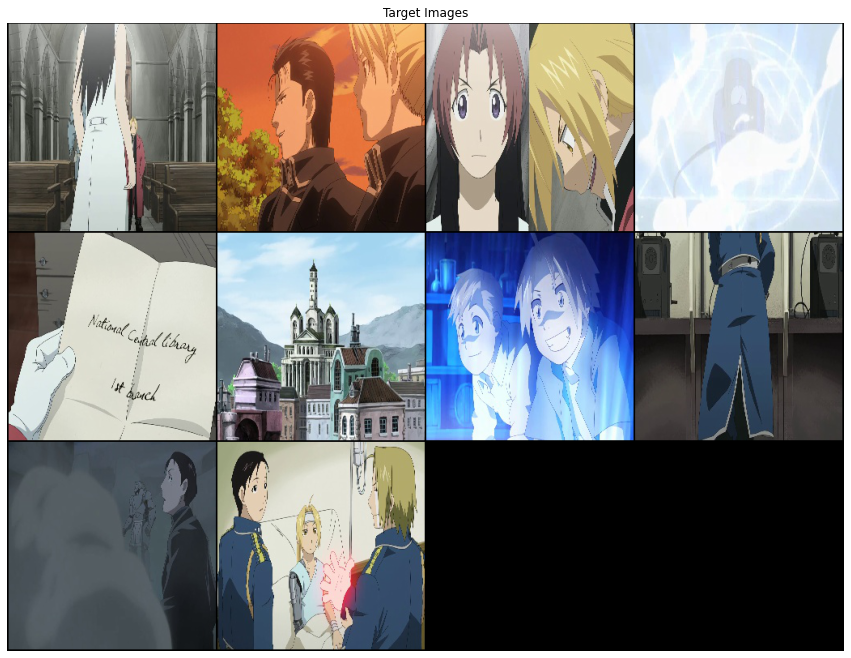

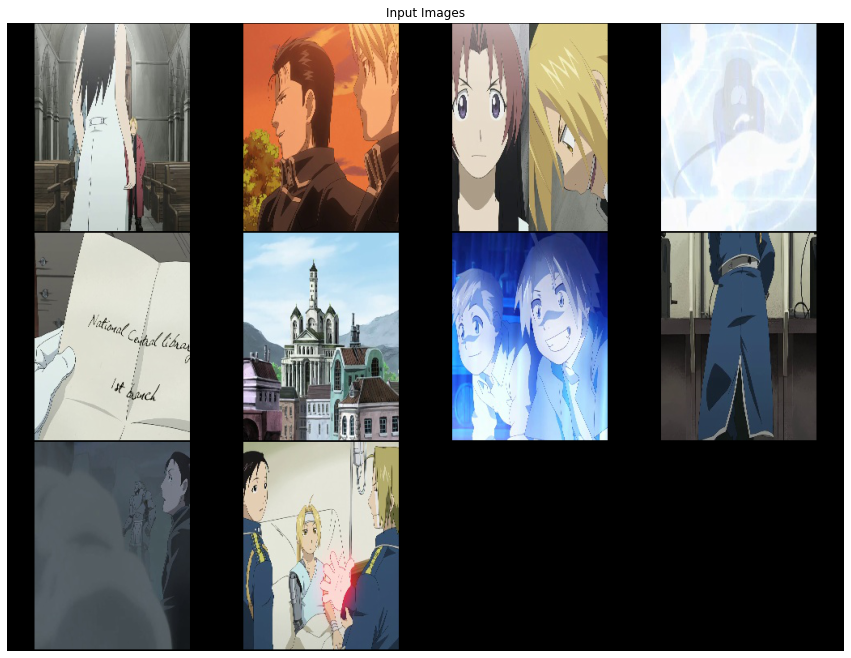

In [8]:
# Plot some training images
batch = next(iter(dataloader_train))
batch_input = batch[0]
batch_target = batch[1]

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_target.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch_input.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

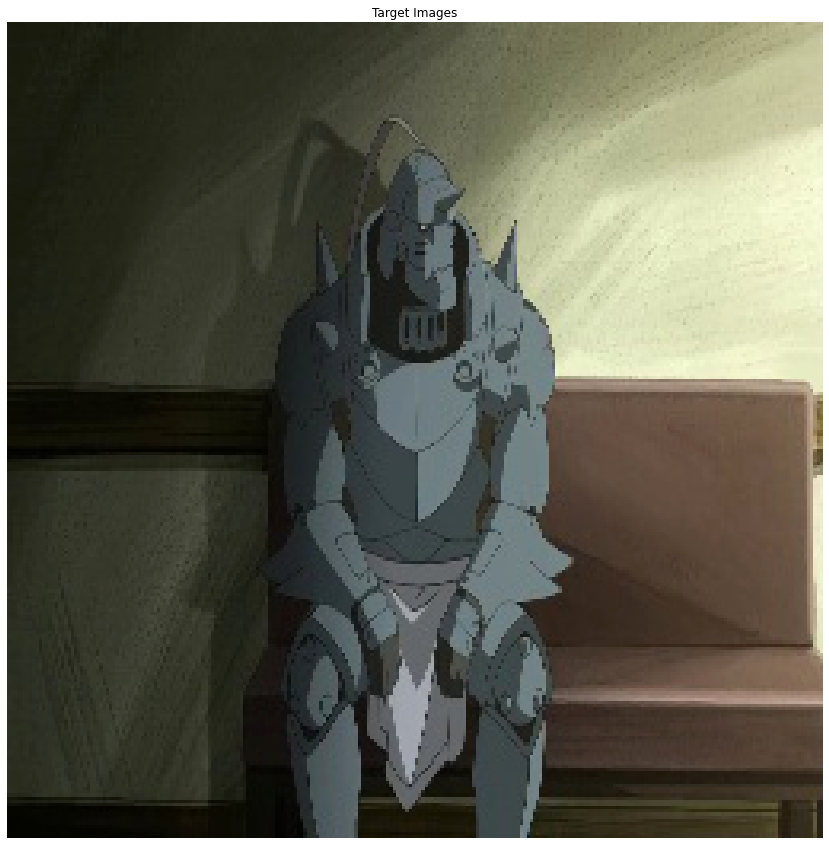

In [9]:
# Plot the image that will be logged to tensorboard
batch = next(iter(dataloader_test))
batch_input = batch[0]
batch_target = batch[1]

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_target.to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

## Network

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.encode1 = nn.Conv2d(3, 6, 4, 2, 1, bias=False)
        self.encode2 = nn.Conv2d(6, 12, 4, 2, 1, bias=False)
        self.encode3 = nn.Conv2d(12, 24, 4, 2, 1, bias=False)      
        self.encode4 = nn.Conv2d(24, 48, 4, 2, 1, bias=False)

        self.decode1 = nn.ConvTranspose2d(48, 24, 4, 2, 1, bias=False)
        self.decode2 = nn.ConvTranspose2d(24, 12, 4, 2, 1, bias=False)
        self.decode3 = nn.ConvTranspose2d(12, 6, 4, 2, 1, bias=False)
        self.decode4 = nn.ConvTranspose2d(6, 3, 4, 2, 1, bias=False)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm6 = nn.BatchNorm2d(6)
        self.batch_norm12 = nn.BatchNorm2d(12)
        self.batch_norm24 = nn.BatchNorm2d(24)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # encoding
        x = self.encode1(x) # output size 128
        x = self.batch_norm6(x)
        x = self.relu(x)

        x = self.encode2(x) # output size 64
        x = self.batch_norm12(x)
        x = self.relu(x)

        x = self.encode3(x) # output size 32
        x = self.batch_norm24(x)
        x = self.relu(x)
        
        # decoding
        x = self.decode2(x) # output size 64
        x = self.batch_norm12(x)
        x = self.relu(x)        

        x = self.decode3(x) # output size 128
        x = self.batch_norm6(x)
        x = self.relu(x)        

        x = self.decode4(x) # output size 256
        x = self.batch_norm3(x)
        x = self.tanh(x)

        return x

In [12]:
gen = Generator(N_GPU).to(device)
gen.apply(weights_init)

Generator(
  (encode1): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encode2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encode3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encode4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (decode1): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (decode2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (decode3): ConvTranspose2d(12, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (decode4): ConvTranspose2d(6, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm6): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm12): BatchNorm2d(12, eps=1

### Testing Generator output

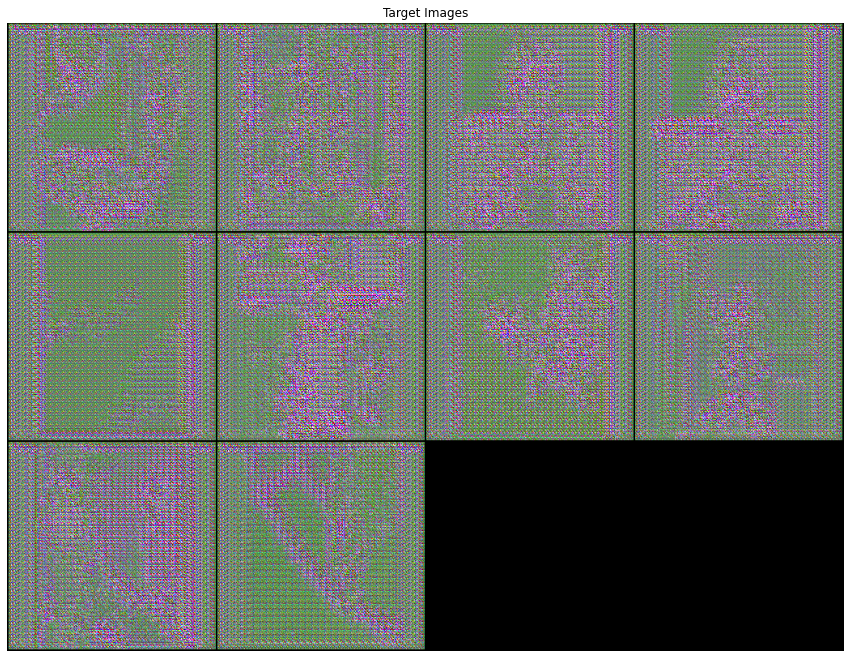

In [13]:
batch = next(iter(dataloader_train))
batch_input = batch[0]
batch_target = batch[1]
gen_output = gen(batch_input)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(gen_output.to(device)[:64], padding=2, normalize=True, nrow=4).detach().numpy(), (1,2,0)))

### Loss Function and Optimizer

In [14]:
loss = nn.MSELoss()
optimizer = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

## Loads Checkpoints

In [15]:
if CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
    gen.load_state_dict(checkpoint['gen_state'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOG_DIR + 'itercount.txt', 'r') as f:
        batch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    batch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOG_DIR)
        print('Folders removed')
    except FileNotFoundError:
        print('No log folder found')

    batch_counter = 1

else:
    print('Failed to specify a type')

Checkpoint Loaded


## Training

In [ ]:
writer = SummaryWriter(LOG_DIR)

# trianing loop
for epoch in range(N_EPOCHS):

    running_loss = 0
    for i, data in enumerate(dataloader_train, 0):
        inputs, targets = data

        # reset the optimizer
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = gen(inputs)
        loss_value = loss(outputs, targets)
        loss_value.backward()
        optimizer.step()

        # print statistics
        running_loss += loss_value.item()
        if i % 10 == 9:
            print('[Epochs: %d/%d, Total Batches: %d, Images: %d/%d] loss: %.3f' % (epoch + 1, N_EPOCHS, batch_counter, i + 1, n_batches, running_loss / 9))
            running_loss = 0.0

            # saves loss to the tensorboard log    
            writer.add_scalar('Loss/Training', loss_value.item(), batch_counter)

            # saves a checkpoint        
            checkpoint = {'gen_state': gen.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint, LOG_DIR + 'checkpoint.pt')

            # Saves an image so we can view the progression
            batch = next(iter(dataloader_test))
            with torch.no_grad():
                output = gen(batch[0]).detach().cpu()
            grid = torchvision.utils.make_grid(output, normalize=True)
            writer.add_image('image_epoch_%d' % batch_counter, grid)

            # saves the epoch counter
            with open(LOG_DIR + '/itercount.txt', 'w') as f:
                f.write(str(batch_counter))

            batch_counter += 1

writer.close()

[Epochs: 1/10, Total Epochs: 325, Batches: 10/2400] loss: 0.086
[Epochs: 1/10, Total Epochs: 326, Batches: 20/2400] loss: 0.091
[Epochs: 1/10, Total Epochs: 327, Batches: 30/2400] loss: 0.096
[Epochs: 1/10, Total Epochs: 328, Batches: 40/2400] loss: 0.094
[Epochs: 1/10, Total Epochs: 329, Batches: 50/2400] loss: 0.087
[Epochs: 1/10, Total Epochs: 330, Batches: 60/2400] loss: 0.093
[Epochs: 1/10, Total Epochs: 331, Batches: 70/2400] loss: 0.083
[Epochs: 1/10, Total Epochs: 332, Batches: 80/2400] loss: 0.090
[Epochs: 1/10, Total Epochs: 333, Batches: 90/2400] loss: 0.092
[Epochs: 1/10, Total Epochs: 334, Batches: 100/2400] loss: 0.088
[Epochs: 1/10, Total Epochs: 335, Batches: 110/2400] loss: 0.093
[Epochs: 1/10, Total Epochs: 336, Batches: 120/2400] loss: 0.092
[Epochs: 1/10, Total Epochs: 337, Batches: 130/2400] loss: 0.084
[Epochs: 1/10, Total Epochs: 338, Batches: 140/2400] loss: 0.093
[Epochs: 1/10, Total Epochs: 339, Batches: 150/2400] loss: 0.087
[Epochs: 1/10, Total Epochs: 340, 

In [ ]:
# writer.close()
epoch_counter